### Experiments of basic ops

In [6]:
include("PES_models_bonding_features.jl") # need to reload everytime a change occurs

multirestart (generic function with 1 method)

#### Reverse AD experiments

In [3]:
# try reverseDiff and optimize:
f(x, c) = c*x.^2 # model to be optimized, minimizer is c = 1
y = [9., 4., 1., 0, 1., 4.] # actual data
x = [-3., -2., -1., 0., 1., 2.] # input data, try matrix form
c = 2.
println(f(x, c))
f_ls_close(c) = f_least_squares(f, y, x, c) # wrapper for ls
println(f_ls_close(c))
∇f(c) = Zygote.gradient(cc -> f_least_squares(f, y, x, cc[1]), [c])[1] #closure for gradient
∇f(c)

[18.0, 8.0, 2.0, 0.0, 2.0, 8.0]
115.0


1-element Zygote.OneElement{Float64, 1, Tuple{Int64}, Tuple{Base.OneTo{Int64}}}:
 230.0

In [53]:
r = optimize(c -> f_ls_close(c[1]), c -> ∇f(c[1]), [c], Optim.Options(iterations = 10, show_trace=true); inplace=false)

Iter     Function value   Gradient norm 
     0     1.150000e+02     2.300000e+02
 * time: 0.0
     1     0.000000e+00     0.000000e+00
 * time: 0.0


 * Status: success

 * Candidate solution
    Final objective value:     0.000000e+00

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 1.00e+00 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.00e+00 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.15e+02 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = Inf ≰ 0.0e+00
    |g(x)|                 = 0.00e+00 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    1
    f(x) calls:    3
    ∇f(x) calls:   3


In [54]:
r.minimizer

1-element Vector{Float64}:
 1.0

In [57]:
f(x) = (1.0 - x[1])^2 + 100.0 * (x[2] - x[1]^2)^2

function g!(G, x)
    G[1] = -2.0 * (1.0 - x[1]) - 400.0 * (x[2] - x[1]^2) * x[1]
    G[2] = 200.0 * (x[2] - x[1]^2)
end

function g2!(G, x, a, b)
    G[1] = -2.0 * (1.0 - x[1]) - 400.0 * (x[2] - x[1]^2) * x[1] + a
    G[2] = 200.0 * (x[2] - x[1]^2) + b
end

const c1 = 0.
const c2 = 0.
function g2_wrap!(G, x)
    return g2!(G, x, c1, c2)
end

function g3(x)
    G = Vector{Float64}(undef, length(x))
    G[1] = -2.0 * (1.0 - x[1]) - 400.0 * (x[2] - x[1]^2) * x[1]
    G[2] = 200.0 * (x[2] - x[1]^2)
    return G
end

function g_AD(f, x)
    return Zygote.gradient(f, x)[1]
end

x0 = [0.0, 0.0]
#optimize(f, g!, x0)
#optimize(f, g2_wrap!, x0)
#optimize(f, x -> g2!(zeros(length(x0)), x, 0., 0.), x0) #<<---- doesnt work
r = optimize(f, x -> g_AD(f, x), x0; inplace = false)

 * Status: success

 * Candidate solution
    Final objective value:     5.191703e-27

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 4.58e-11 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.58e-11 ≰ 0.0e+00
    |f(x) - f(x')|         = 4.41e-19 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 8.50e+07 ≰ 0.0e+00
    |g(x)|                 = 1.44e-13 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    24
    f(x) calls:    67
    ∇f(x) calls:   67


In [58]:
r.minimizer

2-element Vector{Float64}:
 0.999999999999928
 0.9999999999998559

#### NLS experiments

In [19]:
# t: array of independent variables
# p: array of model parameters

# when the gradients are large, the optimization using the AD gives incorrect result (?)
m(t, p) = p[1] * exp.(p[2] * t)
∇m(t, p) = Zygote.jacobian(p -> m(t,p), p)[1] # extract tuple
function j_m(t,p)
    J = Array{Float64}(undef, length(t),length(p))
    J[:,1] = exp.(p[2] .* t)       #df/dp[1]
    J[:,2] = t .* p[1] .* J[:,1]   #df/dp[2]
    return J
end
p0 = [0.5, 0.5]
tdata = collect(LinRange(0,10,20))
#ydata = m(tdata, [1., 3.1])
ydata = m(tdata, [5.0, 1.3]) + 0.01*randn(length(tdata))
display(∇m(tdata, p0))
display(j_m(tdata, p0))
fit = LsqFit.curve_fit(m, ∇m, tdata, ydata, p0, show_trace=true)

20×2 Matrix{Float64}:
   1.0        0.0
   1.30103    0.342377
   1.69268    0.890887
   2.20224    1.73861
   2.86518    3.01598
   3.72769    4.90486
   4.84985    7.65765
   6.30981   11.6233
   8.20926   17.2827
  10.6805    25.296
  13.8957    36.5676
  18.0787    52.3332
  23.521     74.2769
  30.6016   104.69
  39.8137   146.682
  51.7989   204.469
  67.392    283.756
  87.6792   392.249
 114.073    540.348
 148.413    742.066

20×2 Matrix{Float64}:
   1.0        0.0
   1.30103    0.342377
   1.69268    0.890887
   2.20224    1.73861
   2.86518    3.01598
   3.72769    4.90486
   4.84985    7.65765
   6.30981   11.6233
   8.20926   17.2827
  10.6805    25.296
  13.8957    36.5676
  18.0787    52.3332
  23.521     74.2769
  30.6016   104.69
  39.8137   146.682
  51.7989   204.469
  67.392    283.756
  87.6792   392.249
 114.073    540.348
 148.413    742.066

     0     6.563241e+12              NaN
 * lambda: 10.0

     1     6.563241e+12     2.591640e+09
 * g(x): 2.591639831896396e9
 * lambda: 100.0
 * dx: [827.2528594140493, 186.65296930465558]

     2     6.563241e+12     2.591640e+09
 * g(x): 2.591639831896396e9
 * lambda: 1000.0
 * dx: [97.63461675034387, 21.874448168886328]

     3     6.563241e+12     2.591640e+09
 * g(x): 2.591639831896396e9
 * lambda: 10000.0
 * dx: [9.941935375987685, 2.2258594349669005]

     4     6.549845e+12     2.588725e+09
 * g(x): 2.5887246969161644e9
 * lambda: 1000.0
 * dx: [0.9960135074347357, 0.22297767231505491]

     5     6.499931e+12     6.742224e+10
 * g(x): 6.742224053495961e10
 * lambda: 100.0
 * dx: [1.2995437184614391, 0.09237352055623797]

     6     5.318620e+12     2.800727e+11
 * g(x): 2.8007268411030835e11
 * lambda: 10.0
 * dx: [5.32511323366581, 0.20012922601423036]

     7     2.636252e+12     4.046490e+12
 * g(x): 4.046490185259882e12
 * lambda: 1.0
 * dx: [6.003533139723561, 0.076392

LsqFit.LsqFitResult{Vector{Float64}, Vector{Float64}, Matrix{Float64}, Vector{Float64}}([4.99999973538031, 1.3000000049905103], [0.005639923605063046, 0.0025056999401904534, 0.02249913494525302, -0.0013100915160677573, 0.0021325678440717866, 0.0025457911105206676, -0.016281799101136585, 0.002396355397991101, 0.006985252297454281, 0.011781346100633527, -0.009414996458872338, 0.009993928209951264, 0.008879334560333518, 0.0015716631460236385, -0.007188250237959437, 0.002912021445808932, -0.01138766430085525, 0.007999738678336143, -0.0004891338758170605, -0.00041779782623052597], [1.0 0.0; 1.982206323132747 5.216332153227849; … ; 223192.41388979173 1.0572271677358592e7; 442413.41408760665 2.2120669533667326e7], true, Float64[])

In [18]:
fit.param

2-element Vector{Float64}:
 5.000001548777902
 1.2999999687649013

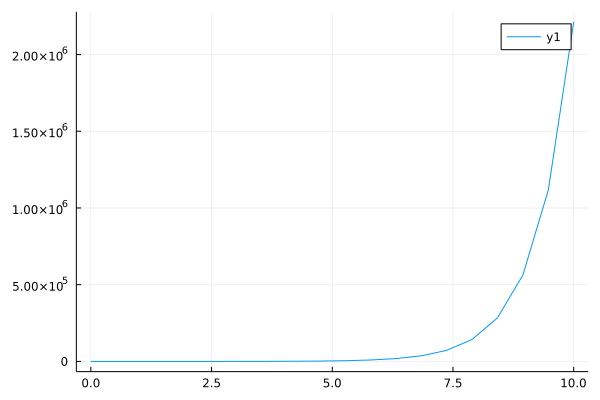

In [4]:
plot(tdata, ydata)

In [50]:
# main caller for tchebyshev primitive
H_data = readdlm("data/h3/h3_data.txt")
# load atomic coordinates:
X = npzread("data/h3/h3_coord.npy")
R = H_data[:,1:end-1]; V = H_data[:, end]
n_atom, n_basis, g, e = (3, 59, 6, 3)
r_xy, N, max_deg = (1.4172946, 5, 5)
idxer = atom_indexer(n_atom)
R_h = 0.01; R_C = 2.; R_0 = .9; C = 1.; g = 6

6

In [67]:
U = f_U_bas(R, idxer, C, R_h, R_C, R_0, g)
display(U)

6032×3 Matrix{Float64}:
 -0.300863  -0.282625  -0.184308
 -0.253721  -0.252811  -0.107353
 -0.315268  -0.274512  -0.274512
 -0.315268  -0.245936  -0.245936
 -0.258908  -0.24448   -0.188119
 -0.258908  -0.218936  -0.162575
 -0.211765  -0.196005  -0.0925023
 -0.181165  -0.17877   -0.0446662
 -0.202547  -0.192171  -0.192171
 -0.202547  -0.164519  -0.164519
 -0.202547  -0.142758  -0.142758
 -0.155405  -0.143337  -0.0961947
 -0.155405  -0.126515  -0.079373
  ⋮                    
  0.0        0.0        0.0
  0.0        0.0        0.0
  0.0        0.0        0.0
  0.0        0.0        0.0
  0.303784   0.303784   0.0
  0.363654   0.363654   0.0
  0.232722   0.232722   0.0
  0.322665   0.322665   0.0
  0.384724   0.384724   0.0
  0.416416   0.416416   0.0
  0.293148   0.293148   0.0
  0.418347   0.418347   0.0

In [69]:
ReverseDiff.gradient(x -> f_U_bas(R, idxer, x, R_h, R_C, R_0, g), R_h)

LoadError: MethodError: no method matching ReverseDiff.GradientConfig(::Float64)
[0mClosest candidates are:
[0m  ReverseDiff.GradientConfig([91m::Tuple[39m) at /users/baribowo/.julia/packages/ReverseDiff/Y5qec/src/api/Config.jl:37
[0m  ReverseDiff.GradientConfig([91m::Tuple[39m, [91m::Type{D}[39m) where D at /users/baribowo/.julia/packages/ReverseDiff/Y5qec/src/api/Config.jl:45
[0m  ReverseDiff.GradientConfig([91m::Tuple[39m, [91m::Type{D}[39m, [91m::Vector{ReverseDiff.AbstractInstruction}[39m) where D at /users/baribowo/.julia/packages/ReverseDiff/Y5qec/src/api/Config.jl:45
[0m  ...

In [78]:
Vref_map(R, C, R_h, R_C, R_0, g) = V_ref_pairpot.(R, C, R_h, R_C, R_0, g)
V = Vref_map(R, C, R_h, R_C, R_0, g)
display(V)
#dV = ReverseDiff.gradient(a -> V_ref_pairpot(R[1,1], C, a[1], R_C, R_0, g), [R_h]) # this works
dV = ReverseDiff.jacobian(a -> V_ref_pairpot.(R, C, a[1], R_C, R_0, g), [R_h])

6032×3 Matrix{Float64}:
 -155.932    -79.1213  -64.8722
 -155.932    -42.2907  -41.5799
 -123.154   -123.154   -91.3125
 -123.154   -123.154   -68.9869
 -123.154    -79.1213  -67.8494
 -123.154    -79.1213  -47.8925
 -123.154    -42.2907  -29.978
 -123.154    -18.3835  -16.5126
  -79.1213   -79.1213  -71.0151
  -79.1213   -79.1213  -49.4112
  -79.1213   -79.1213  -32.4104
  -79.1213   -42.2907  -32.8627
  -79.1213   -42.2907  -19.7205
    ⋮                  
    0.0        0.0       0.0
    0.0        0.0       0.0
    0.0        0.0       0.0
    0.0        0.0       0.0
  237.335      0.0       0.0
  284.11       0.0       0.0
  181.817      0.0       0.0
  252.086      0.0       0.0
  300.571      0.0       0.0
  325.331      0.0       0.0
  229.026      0.0       0.0
  326.839      0.0       0.0

LoadError: type Float64 has no field partials

In [80]:
filter(x -> x>0, dV)

Real[]

In [19]:
θ = rand(Distributions.Uniform(-1.,1.), n_basis, 2)
ϕ = rand(size(R)[1], n_basis)

6032×59 Matrix{Float64}:
 0.172833   0.603902   0.849813  …  0.00283603  0.891792   0.805057
 0.734737   0.0560176  0.9826       0.664798    0.82249    0.837309
 0.867118   0.160642   0.574655     0.275104    0.78609    0.258489
 0.357784   0.705913   0.40162      0.627691    0.971502   0.917256
 0.956836   0.41402    0.646161     0.952774    0.587505   0.523302
 0.510945   0.138006   0.103751  …  0.42992     0.438944   0.666345
 0.797843   0.948396   0.671563     0.472452    0.281682   0.430227
 0.120286   0.53105    0.630351     0.812002    0.486732   0.916444
 0.923695   0.436991   0.973181     0.265957    0.906929   0.99399
 0.40185    0.182073   0.37459      0.792847    0.20594    0.153141
 0.692956   0.0693769  0.410325  …  0.440296    0.946885   0.0680272
 0.852201   0.231341   0.407975     0.947575    0.190963   0.191859
 0.593115   0.946838   0.760901     0.510768    0.0990446  0.312396
 ⋮                               ⋱                         
 0.599479   0.534593   0.958716

In [28]:
println(θ[1]," ",ϕ[1])

0.32541648881888996 0.17283315599381788


In [64]:
#f_A(θ, ϕ)
#df = Zygote.jacobian(x -> f_A(θ, ϕ), θ)[1]
df = ReverseDiff.jacobian(x -> f_A(x, ϕ), θ) # works !!

6032×118 Matrix{Float64}:
 0.0215679   0.0753611   0.106048    0.0782405   …  -0.0277046   -0.0250101
 0.0848351   0.00646798  0.113454    0.0324051       0.0183935    0.0187249
 0.0502956   0.00931774  0.0333319   0.0435842       0.0281841    0.00926774
 0.0319165   0.0629718   0.035827    0.0605672      -0.0695093   -0.0656281
 0.192528    0.0833063   0.130016    0.119665        0.00373433   0.00332624
 0.0414149   0.0111861   0.00840958  0.0263798   …  -0.0170533   -0.025888
 0.16678     0.198252    0.140383    0.0649896       0.00240544   0.00367394
 0.0623139   0.27511     0.326553    0.14322        -0.498538    -0.938673
 0.199104    0.0941943   0.209771    0.0286547       0.108834     0.119282
 0.0216027   0.00978792  0.0201373   0.0110231       0.00428695   0.00318785
 0.0300284   0.00300636  0.0177809   0.0311878   …   0.0114562    0.000823048
 0.0405828   0.0110167   0.0194282   0.00210077      0.00514969   0.00517383
 0.590153    0.942109    0.757101    0.871511        0.023

In [66]:
df = Zygote.jacobian(x -> f_A(x, ϕ), θ)[1] # zygote is faster

6032×118 Matrix{Float64}:
 0.0215679   0.0753611   0.106048    0.0782405   …  -0.0277046   -0.0250101
 0.0848351   0.00646798  0.113454    0.0324051       0.0183935    0.0187249
 0.0502956   0.00931774  0.0333319   0.0435842       0.0281841    0.00926774
 0.0319165   0.0629718   0.035827    0.0605672      -0.0695093   -0.0656281
 0.192528    0.0833063   0.130016    0.119665        0.00373433   0.00332624
 0.0414149   0.0111861   0.00840958  0.0263798   …  -0.0170533   -0.025888
 0.16678     0.198252    0.140383    0.0649896       0.00240544   0.00367394
 0.0623139   0.27511     0.326553    0.14322        -0.498538    -0.938673
 0.199104    0.0941943   0.209771    0.0286547       0.108834     0.119282
 0.0216027   0.00978792  0.0201373   0.0110231       0.00428695   0.00318785
 0.0300284   0.00300636  0.0177809   0.0311878   …   0.0114562    0.000823048
 0.0405828   0.0110167   0.0194282   0.00210077      0.00514969   0.00517383
 0.590153    0.942109    0.757101    0.871511        0.023

In [70]:
df_T = Zygote.jacobian(x -> f_T0(x, ϕ), θ)[1]

6032×118 Matrix{Float64}:
  0.0162468     0.0567686    0.079885   …  -0.0104348    -0.00941989
 -0.0514146    -0.00391994  -0.0687592     -0.00557372   -0.00567415
 -0.133002     -0.0246399   -0.0881432     -0.0372652    -0.0122539
  0.0898075     0.177192     0.100811      -0.0977934    -0.0923329
 -0.0151703    -0.00656416  -0.0102447     -0.000147124  -0.000131047
  0.0727341     0.0196455    0.0147692  …  -0.0149748    -0.0227327
 -0.0167556    -0.0199174   -0.0141036     -0.000120831  -0.000184552
  0.246567      1.08857      1.29212       -0.986323     -1.8571
 -0.269564     -0.127528    -0.284006      -0.0736743    -0.0807467
 -0.0370893    -0.0168047   -0.0345733     -0.00368008   -0.00273658
 -0.041177     -0.00412253  -0.0243824  …  -0.00785476   -0.00056431
 -0.107912     -0.029294    -0.0516606     -0.00684664   -0.00687874
  2.01614       3.21853      2.58649        0.0405389     0.127863
  ⋮                                     ⋱                
  0.0474382     0.0423036  

In [103]:
function f_U_bas_test(R, idxer, arg_vref...)
    """
    U = ∑V_ij
    returns matrix (n_data, n_atom) ∈ Float64
    params:
        - R, matrix of distances, shape = (n_data, n_d) ∈ Float64
        - idxer, matrix containing the atomic indexer, shape = (n_atom-1,n_atom) ∈ Int
        - all params of V_ref_pairpot (arg_vref...)
    """
    n_data = size(R)[1]; n_atom = size(idxer)[2]
    #Vref = V_ref_pairpot.(R, arg_vref...)
    Vref = similar(R)
    rg_natom = 1:n_atom; rg_ndata = 1:n_data
    for j=rg_natom
        for i=rg_ndata
            Vref[i, j] = V_ref_pairpot(R[i,j], arg_vref...)
        end
    end
    U = Matrix{Float64}(undef, n_data, n_atom)
    #U = zeros(n_data, n_atom)
    @simd for i=1:n_atom
        Vsub = @view Vref[:, idxer[:,i]]
        U[:, i] = sum(Vsub, dims=2)
    end
    U = U./maximum(abs.(U)) # scale U, by U:=U/max(abs(U))
    return U
end

f_U_bas_test (generic function with 1 method)

In [84]:
U = f_U_bas_test(R, idxer, C, R_h, R_C, R_0, g)

6032×3 Matrix{Float64}:
 -0.300863  -0.282625  -0.184308
 -0.253721  -0.252811  -0.107353
 -0.315268  -0.274512  -0.274512
 -0.315268  -0.245936  -0.245936
 -0.258908  -0.24448   -0.188119
 -0.258908  -0.218936  -0.162575
 -0.211765  -0.196005  -0.0925023
 -0.181165  -0.17877   -0.0446662
 -0.202547  -0.192171  -0.192171
 -0.202547  -0.164519  -0.164519
 -0.202547  -0.142758  -0.142758
 -0.155405  -0.143337  -0.0961947
 -0.155405  -0.126515  -0.079373
  ⋮                    
  0.0        0.0        0.0
  0.0        0.0        0.0
  0.0        0.0        0.0
  0.0        0.0        0.0
  0.303784   0.303784   0.0
  0.363654   0.363654   0.0
  0.232722   0.232722   0.0
  0.322665   0.322665   0.0
  0.384724   0.384724   0.0
  0.416416   0.416416   0.0
  0.293148   0.293148   0.0
  0.418347   0.418347   0.0

In [105]:
dU = ReverseDiff.jacobian(x -> f_U_bas_test(R, idxer, C, R_h, R_C, ReverseDiff.value(x[1]), g), [R_0])

18096×1 Matrix{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [24]:
function f_test_1(A, x)
    """
    u = Ax + some constant row vector
    """
    u = A*x[2:end] .+ x[1]
    return u
end

function f_test_2(A, x)
    """
    alloc inside
    """
    u = Vector{Float64}(undef, length(x)-1)
    u .= A*x[2:end] .+ x[1]
    return u
end


function f_test_3!(u, A, x)
    """
    non-alloc ver
    """
    u .= A*x[2:end] .+ x[1]
end

# derivative:
J_f_1(A, x) = Zygote.jacobian(θ -> f_test_1(A, θ), x)
J_f_2(A, x) = Zygote.jacobian(θ -> f_test_2(A, θ), x) # try with Enzyme.jl
J_f_3(u, A, x) = Zygote.jacobian(θ -> f_test_3!(u, A, θ), x)

# for testing:
A = Matrix{Float64}(LinearAlgebra.I, 5, 5)
u = Vector{Float64}(undef, 5)
f_test_3!(u, A, ones(6))
display(u)

5-element Vector{Float64}:
 2.0
 2.0
 2.0
 2.0
 2.0

In [17]:
x = ones(6)

6-element Vector{Float64}:
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0

In [25]:
J_f_1(A, x)[1]

5×6 Matrix{Float64}:
 1.0  1.0  0.0  0.0  0.0  0.0
 1.0  0.0  1.0  0.0  0.0  0.0
 1.0  0.0  0.0  1.0  0.0  0.0
 1.0  0.0  0.0  0.0  1.0  0.0
 1.0  0.0  0.0  0.0  0.0  1.0

In [26]:
J_f_2(A, x)

LoadError: UndefVarError: jacobian not defined

In [8]:
J_f_3(u,A,x)

LoadError: Mutating arrays is not supported -- called copyto!(::Vector{Float64}, _...)